In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import itertools 
from os.path import join
from copy import deepcopy
from pdb import set_trace

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
from mne.preprocessing import ICA
from IPython.display import display, clear_output

import deepbci as dbci
from deepbci.data_utils.data import run_group_mutators
from deepbci.utils import utils as dtils

import plot as plts
import vis_utils as vtils
from vis_utils import Tunable, CVConfigManager

In [2]:
def garbage_collect(vars_):
    for v in vars_:
        if v in globals():
            del globals()[v]
    collected = gc.collect()

In [3]:
cfg = 'vis-analysis.yaml'

def load_config(cfg):
    config_path = dtils.path_to(os.getcwd(), cfg)

    yaml_loader = dtils.get_yaml_loader()
    yaml_loader.add_constructor(u'!Tunable', Tunable.tunable_constructor)
    
    return dtils.load_yaml(config_path, loader=yaml_loader)

config = load_config(cfg)
groups = config.pop('groups')

# Rejeceted Epochs

In [4]:
mne.set_log_level('ERROR')

mutate = config['mutate_drop']
print(mutate)
so_cfg = {'groups': groups, 'mutate': mutate}

grps = vtils.instantiate_and_mutate(so_cfg)

[{'apply_func': {'select': None, 'func': {'_partial_': True, '_target_': 'deepbci.data_utils.mutators.filter', 'l_freq': 0.1, 'h_freq': None, 'method': 'iir', 'verbose': False, 'iir_params': {'order': 4, 'ftype': 'butter', 'output': 'sos'}}}}, {'apply_func': {'select': None, 'func': {'_partial_': True, '_target_': 'deepbci.data_utils.mutators.epoch', 'tmin': -0.2, 'tmax': 0.995, 'preload': True, 'picks': ['eeg'], 'verbose': 'WARNING', 'baseline': None}}}, {'compress': {'compress_level': 'subject'}}, {'apply_func': {'select': [['dbci'], ['BGSObs', 'BGSInt']], 'func': {'_partial_': True, '_target_': 'deepbci.data_utils.mutators.reject_epochs', 'reject': {'eeg': 4.9999999999999996e-05}}}}, {'apply_func': {'select': [['dbci'], ['OAObs', 'OAOut']], 'func': {'_partial_': True, '_target_': 'deepbci.data_utils.mutators.reject_epochs', 'reject': {'eeg': 9.999999999999999e-05}}}}]


In [5]:
print(grps)

group  dataset  subject  trial
dbci   BGSInt   1        NaN      DataGroup(BaseEpochs, ndarray)
                2        NaN      DataGroup(BaseEpochs, ndarray)
                3        NaN      DataGroup(BaseEpochs, ndarray)
                4        NaN      DataGroup(BaseEpochs, ndarray)
                5        NaN      DataGroup(BaseEpochs, ndarray)
                6        NaN      DataGroup(BaseEpochs, ndarray)
                7        NaN      DataGroup(BaseEpochs, ndarray)
                8        NaN      DataGroup(BaseEpochs, ndarray)
                9        NaN      DataGroup(BaseEpochs, ndarray)
       BGSObs   1        NaN      DataGroup(BaseEpochs, ndarray)
                2        NaN      DataGroup(BaseEpochs, ndarray)
                3        NaN      DataGroup(BaseEpochs, ndarray)
                4        NaN      DataGroup(BaseEpochs, ndarray)
                5        NaN      DataGroup(BaseEpochs, ndarray)
                6        NaN      DataGroup(BaseEpochs, nda

In [6]:
# Example of how to index Groups.data_map
grps['dbci', ['OAOut', 'BGSInt']]

array([DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray),
       DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray),
       DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray),
       DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray),
       DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray),
       DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray),
       DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray),
       DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray),
       DataGroup(BaseEpochs, ndarray), DataGroup(BaseEpochs, ndarray)],
      dtype=object)

In [7]:
drop_df = vtils.get_drop_logs(grps)
drop_df

percent  dropped  total
group dataset subject trial                          
dbci  BGSInt  1       NaN    0.724868      137    189
              2       NaN    0.870370      188    216
              3       NaN    0.419913       97    231
              4       NaN    0.447917       86    192
              5       NaN    0.924779      209    226
              6       NaN    0.564444      127    225
              7       NaN    0.985981      211    214
              8       NaN    0.177340       36    203
              9       NaN    0.300000       60    200
      BGSObs  1       NaN    0.650943      138    212
              2       NaN    0.807487      151    187
              3       NaN    0.178571       35    196
              4       NaN    0.095694       20    209
              5       NaN    0.705584      139    197
              6       NaN    0.232143       52    224
              7       NaN    0.873239      186    213
              8       NaN    0.109005       23    211
              9       NaN    0.158120       37    234
      OAObs   1       NaN    0.023810        3    126
              2       NaN    0.106557       13    122
              3       NaN    0.018519        2    108
              4       NaN    0.017094        2    117
              5       NaN    0.066667        7    105
              6       NaN    0.000000        0    115
              7       NaN    0.009259        1    108
              8       NaN    0.044248        5    113
              9       NaN    0.010101        1     99
      OAOut   1       NaN    0.044944        4     89
              2       NaN    0.281690       20     71
              3       NaN    0.099010       10    101
              4       NaN    0.121622       18    148
              5       NaN    0.463768       32     69
              6       NaN    0.054902       14    255
              7       NaN    0.033557        5    149
              8       NaN    0.014286        1     70
              9       NaN    0.119565       11     92

Check how many samples were dropped for each DataGroup object in Groups.

In [8]:
group = ['dbci']
dataset = ['OAOut']
subject = ['1']
trial = ['6']

if grps.data_map.index.get_level_values('trial')[0] == grps._compressed_key:
    print(f"Trials were compressed the value {trial} will not be used.")
    data = grps[group, dataset, subject][0].data
else:
    data = grps[group, dataset, subject, trial][0].data

if isinstance(data, (mne.io.Raw, mne.io.RawArray,)):
    events = data.find_events(raw)
else:
    events = data.events

print(f"Epochs: {len(data.events)}")

Trials were compressed the value ['6'] will not be used.
Epochs: 85


# Filtering Example

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
def plot_signal(t, y, title=''):
    plt.figure(figsize = (8, 2.5))
    plt.hlines(0, np.min(t), np.max(t), colors='gray', linestyles='dashed')
    plt.plot(t, y, 'b')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.ylim(-2, 3)
    plt.title(title)
    plt.show()
    
def plot_signal_and_target(t, signal, target, title=''):
    plt.figure(figsize = (8, 2.5))
    plt.hlines(0, np.min(t), np.max(t), colors='gray', linestyles='dashed')
    plt.plot(t, target, '--r', label='target')
    plt.plot(t, signal, 'b', label='signal')
    plt.legend()
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.ylim(-2, 3)
    plt.title(title)
    plt.show()


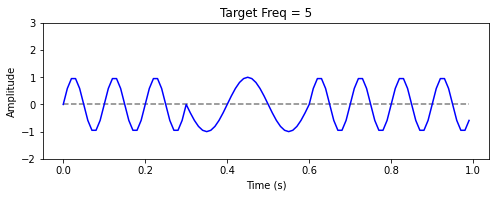

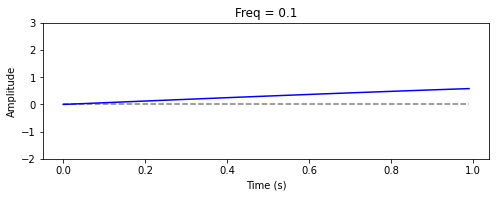

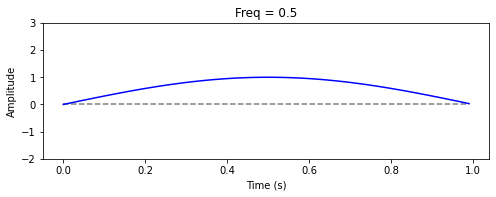

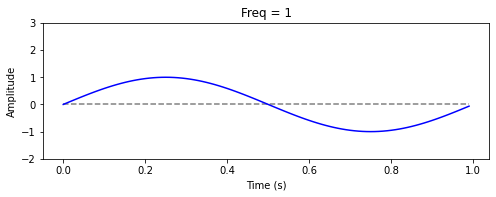

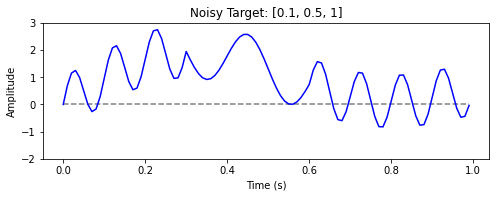

In [11]:
# sampling rate
sr = 100.0
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

# Target signal
freq = 5   
target = np.sin(2*np.pi*freq*t) 
target[:30] = np.sin(2*np.pi*10*t)[:30] 
target[60:] = np.sin(2*np.pi*10*t)[60:] 

plot_signal(t, target, f"Target Freq = {freq}")

noise_freqs = [.1, .5, 1]
noise_y = target
for nf in noise_freqs:
    y = np.sin(2*np.pi*nf*t)
    plot_signal(t, y, f"Freq = {nf}")
    noise_y = noise_y + y
    
plot_signal(t, noise_y, f"Noisy Target: {noise_freqs}")    


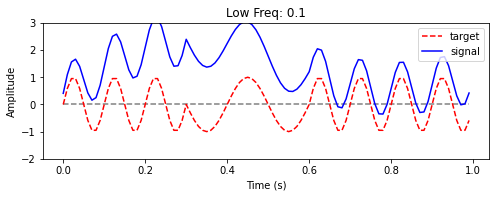

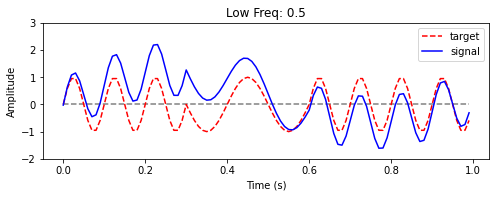

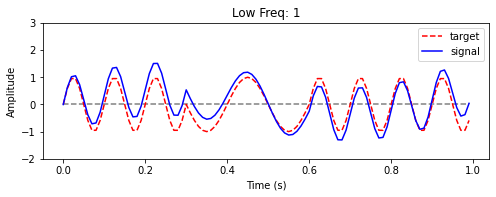

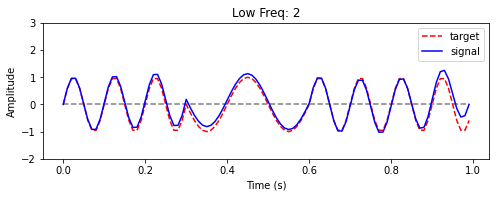

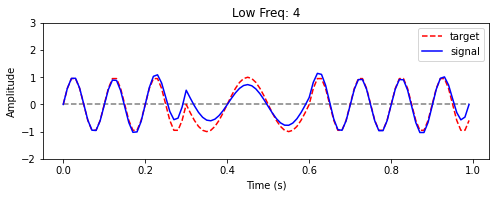

In [12]:
iir_params = dict(order=4, ftype='butter', output='sos')
l_freqs = [.1, .5, 1, 2, 4]
for lf in l_freqs:
    y_new = mne.filter.filter_data(
        noise_y,
        sfreq=sr,
        l_freq=lf,
        h_freq=None,
        method='iir',
        verbose=False,
        iir_params=iir_params
    )
    plot_signal_and_target(t, y_new, target, f"Low Freq: {lf}") 

/tmp/ipykernel_681/2896394655.py:3: RuntimeWarning: filter_length (3301) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  y_new = mne.filter.filter_data(


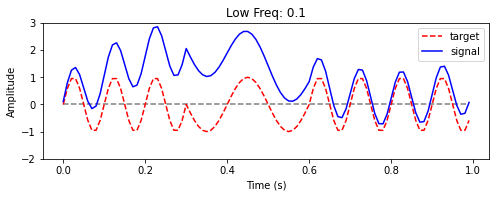

/tmp/ipykernel_681/2896394655.py:3: RuntimeWarning: filter_length (661) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  y_new = mne.filter.filter_data(


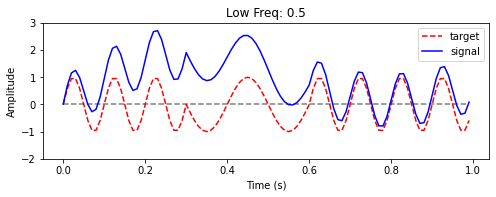

/tmp/ipykernel_681/2896394655.py:3: RuntimeWarning: filter_length (331) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  y_new = mne.filter.filter_data(


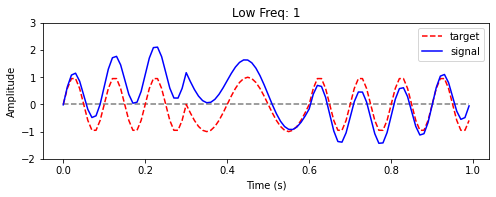

/tmp/ipykernel_681/2896394655.py:3: RuntimeWarning: filter_length (165) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  y_new = mne.filter.filter_data(


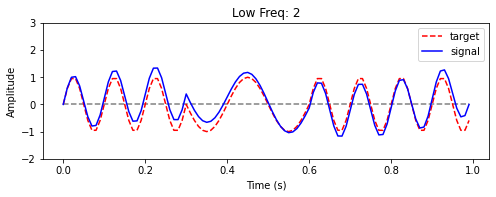

/tmp/ipykernel_681/2896394655.py:3: RuntimeWarning: filter_length (165) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  y_new = mne.filter.filter_data(


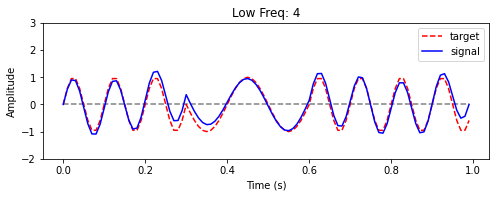

In [13]:
l_freqs = [.1, .5, 1, 2, 4]
for lf in l_freqs:
    y_new = mne.filter.filter_data(
        noise_y,
        sfreq=sr,
        l_freq=lf,
        h_freq=None,
        method='fir',
        verbose=False,
        phase='zero-double'
    )
    plot_signal_and_target(t, y_new, target, f"Low Freq: {lf}") 

Let's see how the signal distorts if it is already "clean".

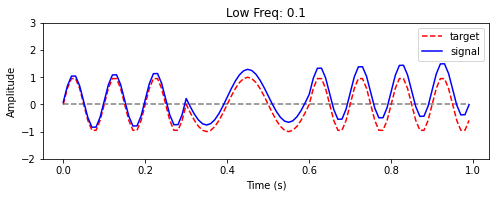

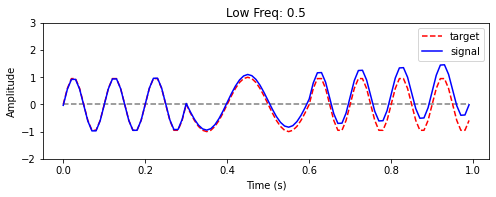

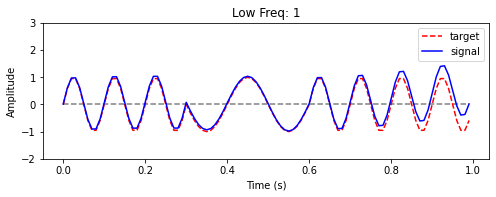

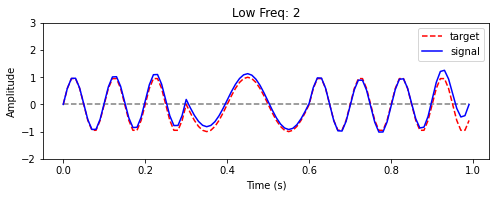

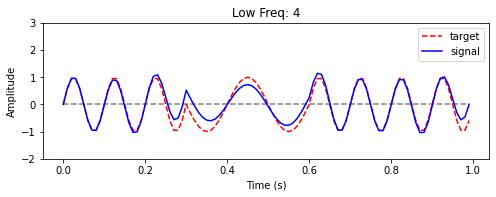

In [14]:
iir_params = dict(order=4, ftype='butter', output='sos')
l_freqs = [.1, .5, 1, 2, 4]
for lf in l_freqs:
    y_new = mne.filter.filter_data(
        target,
        sfreq=sr,
        l_freq=lf,
        h_freq=None,
        method='iir',
        verbose=False,
        iir_params=iir_params
    )
    plot_signal_and_target(t, y_new, target, f"Low Freq: {lf}") 

Test what happens when we apply the same filter multiple times.

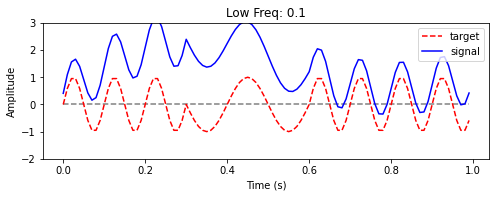

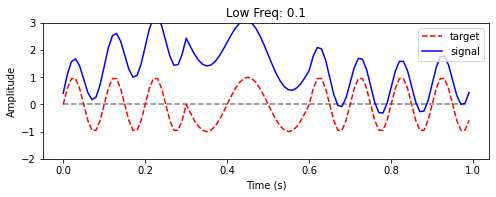

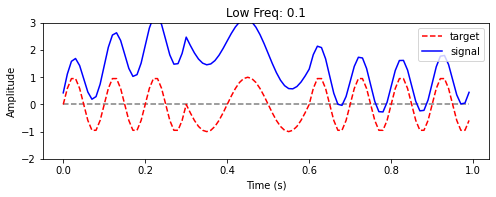

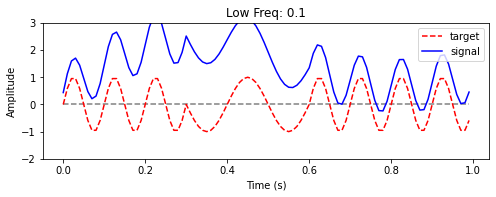

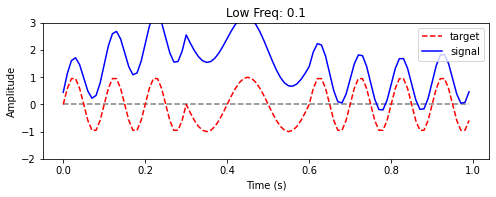

In [15]:
l_freqs = [.1, .1, .1, .1, .1]
y_new = noise_y
for lf in l_freqs:
    y_new = mne.filter.filter_data(
        y_new,
        sfreq=sr,
        l_freq=lf,
        h_freq=None,
        method='iir',
        verbose=False,
        iir_params=iir_params
    )
    plot_signal_and_target(t, y_new, target, f"Low Freq: {lf}") 
    

# Filtering DBCI data

TODO
- Limit the number of samples used for all GAs to that of the smallest sample pool.

In [16]:
def test_plot_grand_average(pa):
    kwargs = dict(
        group = ['dbci'],
        dataset = ['BGSInt', 'BGSObs', 'OAOut', 'OAObs'],
        subject = ['1','2', '3', '4', '5', '6', '7', '8', '9'],
        channel = ['Cz'],
        event = ['1'],
    )

    return pa.plot_grand_average(**kwargs)

## Filter Effects On DBCI Data

Test how different low-pass filters affects epochs dropped and singal average.

TODO: Use baseline filter for dropping with no epoching. Then, once dropped, apply tunable filters to keep number of samples consistent.

In [17]:
from deepbci.data_utils.data import run_group_mutators
from hydra.utils import instantiate
from datetime import datetime

mne.set_log_level('ERROR')
    
config = load_config(cfg)
groups = config.pop('groups')
grps = instantiate(groups, _convert_='all')

Install plotly dependency kaleido

In [18]:
# ! pip install -U kaleido

**WARNING**: This is very slow and will save images to your computer!

In [20]:

def filter_test_exp(ext='jpg'):
    now = datetime.utcnow()
    folder = os.path.join('averages', 'filter_exp', now.strftime('%Y-%m-%d_%H-%M-%S'))
    if not os.path.exists(folder):
        os.makedirs(folder)

    for filter_name, filter_mutate in config['mutate_filter_tests'].items():
        cm = CVConfigManager({filter_name:filter_mutate})
       
        for name, mutate_cfg in cm:
            # Apply mutator with specific tunable
            filt_grps = grps.deepcopy()
            mutate = instantiate(mutate_cfg[filter_name], _convert_='all')
            # print(name, filter_name, mutate_cfg[filter_name])
            run_group_mutators(filt_grps, mutate)
            
            # Generate name for current combination of tunables
            name_string = f'{filter_name}_' + '_'.join([f'{n[0]}-{n[1]}' for n in name])
            
            csv_path = os.path.join(folder, f'{name_string}-dropped.csv')
            dropped_df = vtils.get_drop_logs(filt_grps)
            dropped_df.to_csv(csv_path)
            # display(dropped_df)

            pa = plts.PlotAverages(filt_grps)
            fig = test_plot_grand_average(pa)
            title = f"{filter_name} - "  + ' '.join([f'{n[0]}: {n[1]}' for n in name])
            fig.update_layout(title=title)
            
            image_name = name_string + f".{ext}"
            file_path = os.path.join(folder, image_name)
            fig.write_image(file_path)
            print(f"Saved {image_name}")

            garbage_collect(['filt_grps'])
            
filter_test_exp()

Combo: ('dbci', 'BGSInt', '1', 'Cz')
	Epoch count: 1896
Combo: ('dbci', 'BGSObs', '1', 'Cz')
	Epoch count: 1883
Combo: ('dbci', 'OAObs', '1', 'Cz')
	Epoch count: 1013
Combo: ('dbci', 'OAOut', '1', 'Cz')
	Epoch count: 1044
Saved iir_l_freq-0.1.jpg
Combo: ('dbci', 'BGSInt', '1', 'Cz')
	Epoch count: 1896
Combo: ('dbci', 'BGSObs', '1', 'Cz')
	Epoch count: 1883
Combo: ('dbci', 'OAObs', '1', 'Cz')
	Epoch count: 1013
Combo: ('dbci', 'OAOut', '1', 'Cz')
	Epoch count: 1044
Saved iir_l_freq-1.jpg
Combo: ('dbci', 'BGSInt', '1', 'Cz')
	Epoch count: 1896
Combo: ('dbci', 'BGSObs', '1', 'Cz')
	Epoch count: 1883
Combo: ('dbci', 'OAObs', '1', 'Cz')
	Epoch count: 1013
Combo: ('dbci', 'OAOut', '1', 'Cz')
	Epoch count: 1044
Saved iir_l_freq-2.jpg
Combo: ('dbci', 'BGSInt', '1', 'Cz')
	Epoch count: 1896
Combo: ('dbci', 'BGSObs', '1', 'Cz')
	Epoch count: 1883
Combo: ('dbci', 'OAObs', '1', 'Cz')
	Epoch count: 1013
Combo: ('dbci', 'OAOut', '1', 'Cz')
	Epoch count: 1044
Saved iir_l_freq-3.jpg
Combo: ('dbci', 'B

In [ ]:
# def filter_test_exp(ext='jpg'):
#     mne.set_log_level('ERROR')
    
#     config = load_config(cfg)
#     groups = config.pop('groups')
    
#     now = datetime.utcnow()
#     folder = os.path.join('averages', 'filter_exp', now.strftime('%Y-%m-%d_%H-%M-%S'))
#     if not os.path.exists(folder):
#         os.makedirs(folder)
        
#     for filter_name, filters in config['mutate_filter_tests'].items():
#         cm = CVConfigManager(dict(specific=filters['specific']))
#         grps = vtils.load_data(groups, filters['general'])
#         # Dropped logs
#         csv_path = os.path.join(folder, f'{filter_name}-dropped.csv')
#         dropped_df = vtils.get_drop_logs(grps)
#         dropped_df.to_csv(csv_path)
#         display(dropped_df)

#         for name, mutate in cm:
#             spec_grps = grps.deepcopy()
#             run_group_mutators(spec_grps, mutate['specific'])

#             pa = plts.PlotAverages(spec_grps)
#             fig = test_plot_grand_average(pa)
#             title = f"{filter_name} - "  + ' '.join([f'{n[0]}: {n[1]}' for n in name])
#             fig.update_layout(title=title)
            
#             image_name = f'{filter_name}_' + '_'.join([f'{n[0]}-{n[1]}' for n in name]) + f".{ext}"
#             file_path = os.path.join(folder, image_name)
#             fig.write_image(file_path)
#             print(f"Saved {image_name}")

#             garbage_collect(['spec_grps'])
            
# filter_test_exp()

# Artifact Analysis

In [21]:
from mne.preprocessing import (ICA)

In [25]:
{'groups':groups, 'mutate':mutate['part1']}

{'groups': {'dbci': [{'_target_': 'deepbci.data_utils.data_loaders.load_data',
    'data_loader': {'_target_': 'deepbci.data_utils.data_loaders.BGSIntLoader'},
    'load_method': 'load_to_memory',
    'load_method_kwargs': {'subjects': [1, 2, 3, 4, 5, 6, 7, 8, 9],
     'trials': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
     'data_file': 'eeg.csv',
     'true_fs': False,
     'preload_epoch_indexes': {'generate_sync_epochs': {'use_events': [1,
        2]}}}},
   {'_target_': 'deepbci.data_utils.data_loaders.load_data',
    'data_loader': {'_target_': 'deepbci.data_utils.data_loaders.BGSObsLoader'},
    'load_method': 'load_to_memory',
    'load_method_kwargs': {'subjects': [1, 2, 3, 4, 5, 6, 7, 8, 9],
     'trials': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
     'data_file': 'eeg.csv',
     'true_fs': False,
     'preload_epoch_indexes': {'generate_sync_epochs': {'use_events': [1,
        2]}}}}]},
 'mutate': [{'apply_func': {'select': None,
    'func': {'_partial_': True,
     '_target_': 'deepbci.data

In [28]:
config = load_config(cfg)
groups = config['ica']['groups']
mutate = config['ica']['mutate']

mne.set_log_level('INFO')
grps1 = vtils.instantiate_and_mutate({'groups':groups, 'mutate':mutate['part1']})
grps2 = vtils.instantiate_and_mutate({'groups':groups, 'mutate':mutate['part2']})

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameter

---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter paramete

---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter paramete

---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter paramete

---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter paramete

---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1

- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples

In [29]:
group = ['dbci']
dataset = ['BGSInt']
subject = ['1']
trial = []

EOG_CHANNELS = ['F3', 'F4']
THRESH = 100*1e-6

filt_raw = grps1[group, dataset, subject][0].data.copy()
filt_raw_epochs =  grps1[group, dataset, subject][0].epochs
filt_raw_event_ids = grps1[group, dataset, subject][0].event_ids
epochs = grps2[group, dataset, subject][0].data.copy()

In [30]:
def annotate_eog_events(raw, eog_events):
    onsets = eog_events[:, 0] / raw.info['sfreq'] - 0.25
    durations = [0.5] * len(eog_events)
    descriptions = ['bad blink'] * len(eog_events)
    blink_annot = mne.Annotations(onsets, durations, descriptions,
                                  orig_time=raw.info['meas_date'])
    raw.set_annotations(blink_annot)
    
def find_eog_events(raw, thresh=None, copy=True, plot=True):
    if copy:
        raw = raw.copy()
    
    d = raw.get_data()[:-1, :]
    mne_thresh = (np.max(d) - np.min(d)) / 4
    print(f"Aprrox for automatically computed MNE thresh (no filts): {mne_thresh*1e6}")
    if thresh is not None:
        print(f"Manually set thresh: {thresh*1e6}")
    print("-"*50)
    eog_events = mne.preprocessing.find_eog_events(
        raw, 
        ch_name=EOG_CHANNELS,
        l_freq=None,
        h_freq=None,
        thresh=thresh,
    )
    annotate_eog_events(raw, eog_events)
    
    if plot:
        %matplotlib qt
        raw.plot()

In [31]:
from plot import prepare_subject_df

class ArtifactAnalysis():
    def __init__(self, dfm, sub_n_epochs=None, avg_n_epochs=None, reject=None, ext='jpg'):
        self.dfm = dfm
        self.sub_n_epochs = sub_n_epochs
        self.avg_n_epochs = avg_n_epochs
        self.reject = reject
        self.ext = f".{ext}"
        self._plot_kwargs = dict(kind="line",x="time", y="uV", hue="event", style="channel")
        
        self._root_save_dir = os.path.join('averages', 'artifact_analysis')
        self._info_save_dir = self._create_dir('info')
        self._sa_save_dir = self._create_dir('SA')
        self._ga_save_dir = self._create_dir('GA')
        
    def __call__(self):
        levels = ['group', 'dataset', 'subject']
        groups = self.dfm.groupby(level=levels)

        subject_df = []
        for group_name, group_df in groups:
            data = group_df.ravel()
            
            if len(data) != 1:
                raise ValueError('More than 1 trial detect for subject. Make sure subject trails were compressed during data mutatation!')
            else:
                data = data[0]

            tags = group_df.index.droplevel(level='trial')[0]
            self.avg_n_epochs = self._format_epoch_counts(tags, data) if self.avg_n_epochs is not None else None
            sdf = self._get_subject_df(d=data, tags=tags)
            for l,n in zip(levels, tags):
                sdf[l] = n
            sdf['id'] = sdf['subject'] + '-' + sdf['event'].astype(str) + '-' + sdf['epoch'].astype(str) 
            sdf.set_index(levels, inplace=True)

#             print(f"{sdf.index[0]}")
#             for event, df in sdf.groupby('event'):
#                 print(f"\tEvent: {event}")
#                 print(f"\t\tEpochs: {len(df['epoch'].unique())}")
            subject_df.append(sdf)

        subject_df = pd.concat(subject_df)
        # Plot subject averages
        self._plot_averages(
            subject_df, 
            ['group', 'dataset', 'subject'],
            save_dir=self._sa_save_dir)
        # Plot grand averages
        self._plot_averages(
            subject_df, 
            ['group', 'dataset'],
            save_dir=self._ga_save_dir,
            avg_n_epochs=self.avg_n_epochs)

    def _create_dir(self, name):
        local_dir = os.path.join(self._root_save_dir, name)
        if not os.path.exists(local_dir):
            os.makedirs(local_dir)
            
        return local_dir
    
    def _format_epoch_counts(self, tags, data):
        epochs = {}
        for event in np.unique(data.epochs[:, -1]):
            key = '-'.join(map(str, tags))
            epochs[key] = sub_epoch_count
        return epochs

    def _get_subject_df(self, d, tags):
        raw = d.data.copy()
        erp_events = d.epochs
        event_ids = np.unique(erp_events[:, -1])

        # Annotate eog events for removal
        find_eog_events(raw, thresh=THRESH, copy=False, plot=False)

        # Epoch and reject epochs based on annotations and peak-to-peak rejection
        epochs =  mne.Epochs(
            raw,
            events=erp_events,
            tmin=-0.2, 
            tmax=.995,
            preload=True,
            picks=['eeg'],
            verbose=True,
            baseline=None,
            reject=self.reject,
            reject_by_annotation=True,
        )

        channels = epochs.ch_names
        sdf = prepare_subject_df(
            epochs=epochs,
            event=event_ids,
            tags=tags,
            channel=channels,
            epoch_counts=self.sub_n_epochs)
        # self._record_info()
        return sdf
    
    def _plot_averages(self, subject_df, levels, save_dir, avg_n_epochs=None):
        savg_df = self._compute_average(subject_df, levels=levels, avg_epoch_count=avg_n_epochs)

        avg_grps = savg_df.groupby(levels)
        for name, df in avg_grps:
            name = '-'.join(name)
            g = self._plot_line(
                df.reset_index(), 
                title=name, 
                **self._plot_kwargs
            )
            save_path = os.path.join(save_dir, name+self.ext)
            g.figure.savefig(save_path)
            
#     def _gather_info(self, df, levels)
#         info = {}
#         avg_groups = df.groupby(level=levels)

#         for group_name, group_df in avg_groups:
#             level_info = group_df.index[0][:len(levels)]
#             epoch_info.append(f"{level_info} -")
#             for event, df in group_df.groupby('event'):
#                 event_info = dict(event={
#                     'epochs': len(df['epoch'].unique())
#                 })
#                 i['event'] = event
#                 epoch_count = 
#                 title_info.append(f"Epochs: {epoch_count}")
                
    def _compute_average(self, df, levels, avg_epoch_count=None):
        avg_df = []
        avg_groups = df.groupby(level=levels)

        for group_name, group_df in avg_groups:
            if avg_epoch_count is not None:
                og_levels = group_df.index.names
                samples = group_df['id'].sample(n=avg_epoch_count).values
                group_df = group_df.reset_index().set_index(['id'])[samples].reset_index().set_index(og_levels)

            adf = group_df.groupby(levels+['event', 'time', 'channel']).mean()
            adf.drop('epoch', axis=1, inplace=True)
            adf.index.droplevel(['event', 'time', 'channel'])
            avg_df.append(adf)

        return pd.concat(avg_df, sort=True)

    def _plot_line(self, df, title, **kwargs):
        g = sns.relplot(data=df, **kwargs)
        # Edit FacetGrid
        g.map(plt.axvline, x=0, color="black", dashes=(2, 1), zorder=0)
        g.map(plt.axhline, y=0, color='black')
        g.ax.set_title(title)
        g.tight_layout()
        
        return g


Aprrox for automatically computed MNE thresh (no filts): 300.8234040088143
Manually set thresh: 99.99999999999999
--------------------------------------------------
Using EOG channels: F3, F4
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Filter length: 2000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 126 significant peaks
Number of EOG events detected: 126
Not setting metadata
1032 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1032 events and 240 original time points ...
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['F3', 'Cz']
    R

/tmp/ipykernel_681/625970285.py:7: RuntimeWarning:

Limited 1 annotation(s) that were expanding outside the data range.



Aprrox for automatically computed MNE thresh (no filts): 429.2082335572307
Manually set thresh: 99.99999999999999
--------------------------------------------------
Using EOG channels: F3, F4
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Filter length: 2000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 16 significant peaks
Number of EOG events detected: 16
Not setting metadata
1047 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1047 events and 240 original time points ...
    Rejecting  epoch based on EEG : ['F4', 'F3', 'Fz']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
 

/tmp/ipykernel_681/625970285.py:7: RuntimeWarning:

Limited 1 annotation(s) that were expanding outside the data range.



Aprrox for automatically computed MNE thresh (no filts): 439.3374547159587
Manually set thresh: 99.99999999999999
--------------------------------------------------
Using EOG channels: F3, F4
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Filter length: 2000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 68 significant peaks
Number of EOG events detected: 68
Not setting metadata
1035 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1035 events and 240 original time points ...
    Rejecting  epoch based on EEG : ['F4', 'F3', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1042 events and 240 original time points ...
    Rejecting  epoch based on EEG : ['F4', 'F3', 'Fz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F3']
18 bad epochs dropped
Aprrox for automatically computed MNE thresh (no filts): 575.2821913635833
Manually set thresh: 99.99999999999999
--------------------------------------------------
Using EOG channels: F3, F4
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Filter length: 2000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 247 significant peaks
Number of EOG eve

    Rejecting  epoch based on EEG : ['F3']
9 bad epochs dropped
Aprrox for automatically computed MNE thresh (no filts): 485.6508314215093
Manually set thresh: 99.99999999999999
--------------------------------------------------
Using EOG channels: F3, F4
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Filter length: 2000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 58 significant peaks
Number of EOG events detected: 58
Not setting metadata
1038 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1038 events and 240 original time points ...
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG :

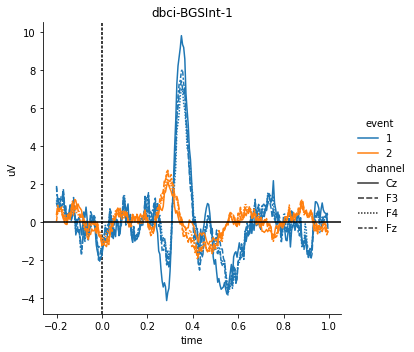

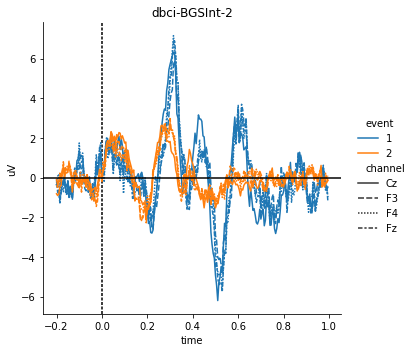

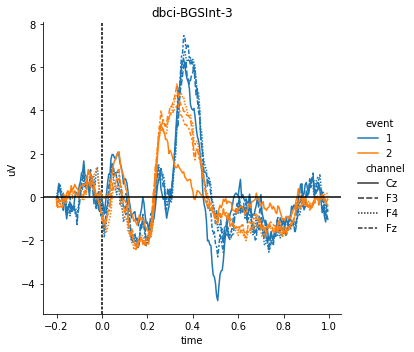

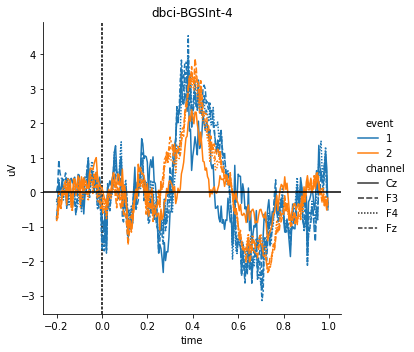

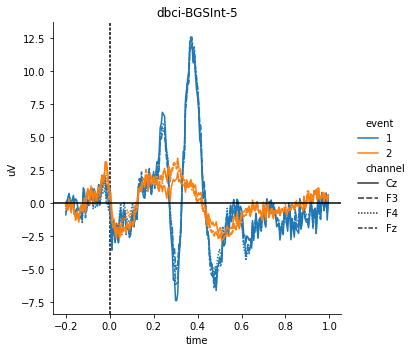

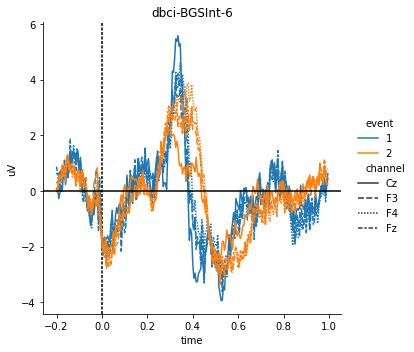

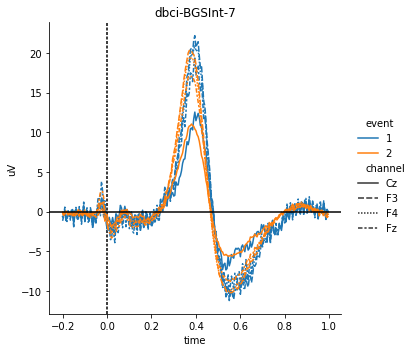

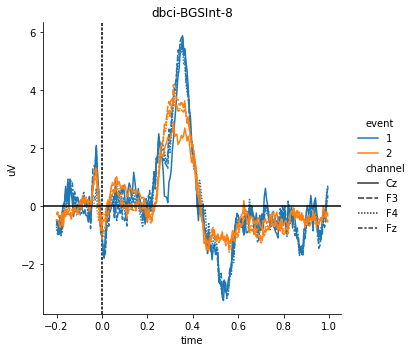

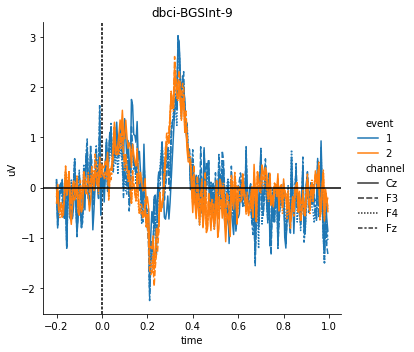

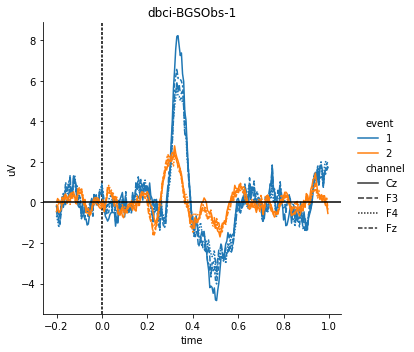

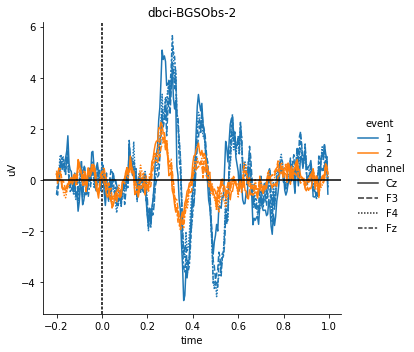

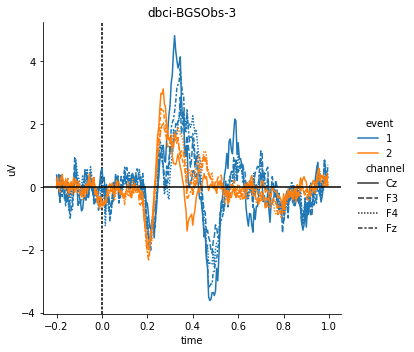

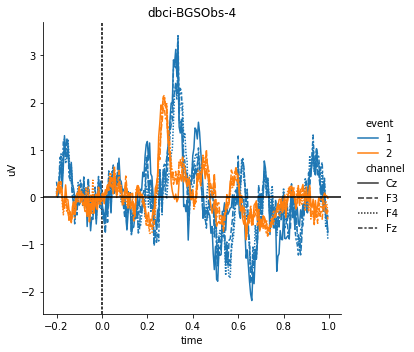

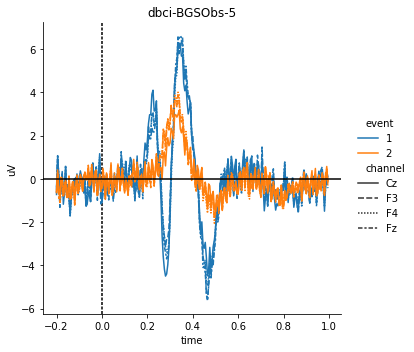

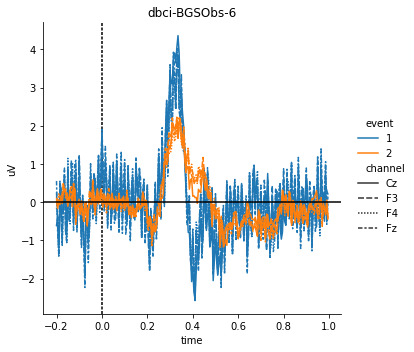

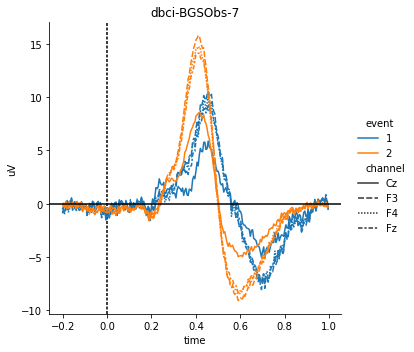

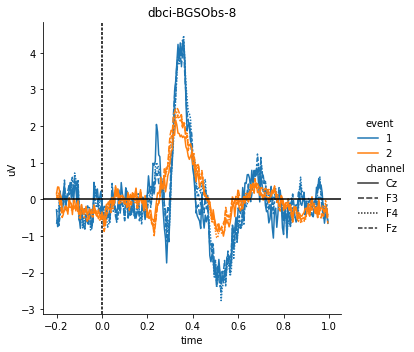

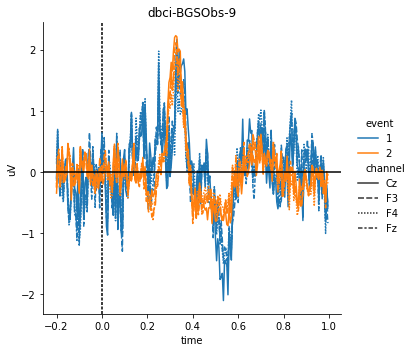

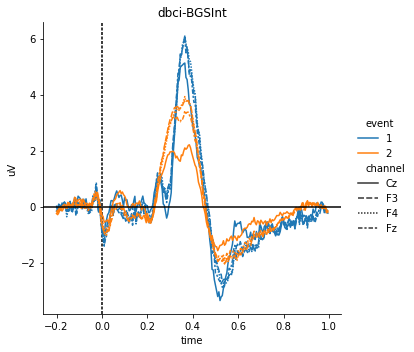

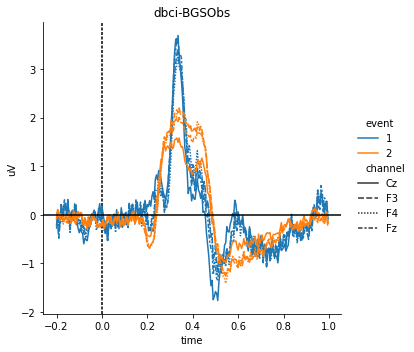

In [32]:
%matplotlib inline
aa = ArtifactAnalysis(grps1.data_map, reject=dict(eeg=THRESH))
aa();

In [33]:
find_eog_events(filt_raw, thresh=THRESH, copy=False, plot=False)
filt_raw.annotations

Aprrox for automatically computed MNE thresh (no filts): 300.8234040088143
Manually set thresh: 99.99999999999999
--------------------------------------------------
Using EOG channels: F3, F4
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Filter length: 2000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 126 significant peaks
Number of EOG events detected: 126


<Annotations | 126 segments: bad blink (126)>

In [172]:
# eog_epochs = mne.preprocessing.create_eog_epochs(
#     filt_raw,
#     thresh=THRESH,
#     ch_name=EOG_CHANNELS,
#     l_freq=None,
#     h_freq=None,
#     baseline=None,
#     reject_by_annotation=False,
#     reject={'eeg': 200*1e-6},
# )
# eog_epochs

In [ ]:
# %matplotlib qt
# eog_epochs.plot();

In [ ]:
# %matplotlib qt
# eog_epochs.average().plot_joint();

In [34]:
epochs_autodroppped =  mne.Epochs(
    filt_raw,
    events=filt_raw_epochs,
    tmin=-0.2, 
    tmax=.995,
    preload=True,
    picks=['eeg'],
    verbose=True,
    baseline=None,
    reject=dict(eeg=THRESH),
    reject_by_annotation=False,
)

Not setting metadata
1032 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1032 events and 240 original time points ...
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['F3', 'Cz']
    Rejecting  epoch based on EEG : ['F4', 'F3', 'Fz']
    Rejecting  epoch based on EEG : ['F4', 'Cz']
    Rejecting  epoch based on EEG : ['F4', 'F3', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F4', 'F3', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['F4', 'F3', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['F3', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['F4', 'F3', 'Fz', 'Cz']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4', 'F3',

In [131]:
n_components = 4
method = 'infomax'
random_state = 0
reject = dict(eeg=200*1e-6)

ica = ICA(n_components=n_components, method=method, 
          random_state=random_state, max_iter=10000)
ica.fit(filt_raw, reject=reject)


Fitting ICA to data using 4 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['F3']
Artifact detected in [40400, 40800]
    Rejecting  epoch based on EEG : ['F4']
Artifact detected in [226400, 226800]
    Rejecting  epoch based on EEG : ['F4']
Artifact detected in [339600, 340000]
    Rejecting  epoch based on EEG : ['F3']
Artifact detected in [376000, 376400]
Selecting by number: 4 components
 
Fitting ICA took 13.1s.


Method,infomax
Fit,10000 iterations on raw data (375600 samples)
ICA components,4
Explained variance,100.0 %
Available PCA components,4
Channel types,eeg
ICA components marked for exclusion,—


Using EOG channels: F3, F4
Excluding Sources: [1]


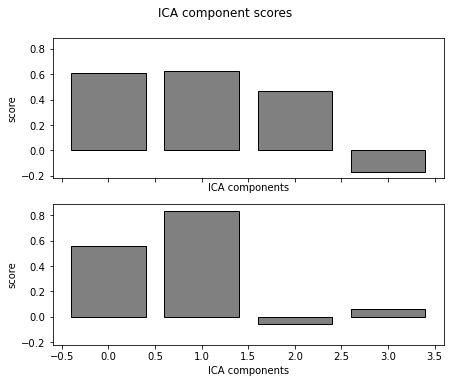

In [132]:
%matplotlib inline
eog_indices, eog_scores = ica.find_bads_eog(
    filt_raw,
    l_freq=None,
    h_freq=None,
    threshold=.7,
    measure='correlation',
    ch_name=EOG_CHANNELS
)
print(f"Excluding Sources: {eog_indices}")
ica.plot_scores(eog_scores);

Applying ICA to Evoked instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


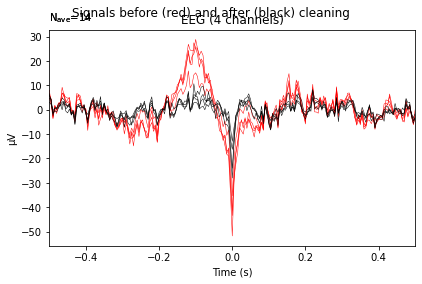

In [134]:
ica.plot_overlay(eog_epochs.average(), exclude=[1]);

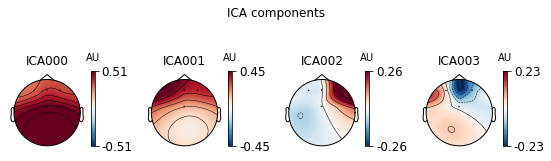

[<MNEFigure size 561.6x187.56 with 8 Axes>]

In [135]:
%matplotlib inline
ica.plot_components(colorbar=True)

In [116]:
def plot_eog_with_sources(raw, eog_events, ica):
    %matplotlib qt
    raw = raw.copy()
    annotate_eog_events(raw, eog_events)
    ica.plot_sources(raw)
    
plot_eog_with_sources(filt_raw, eog_epochs.events, ica);

Creating RawArray with float64 data, n_channels=4, n_times=377202
    Range : 0 ... 377201 =      0.000 ...  1886.005 secs
Ready.
Opening ica-browser...
Closing ica-browser...


In [115]:
%matplotlib qt
ica.plot_sources(filt_raw);

Creating RawArray with float64 data, n_channels=4, n_times=377202
    Range : 0 ... 377201 =      0.000 ...  1886.005 secs
Ready.
Opening ica-browser...
Closing ica-browser...


In [97]:
%matplotlib qt
ica.plot_properties(filt_raw, picks='eeg');

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [166]:
def plot_raw_excluded(raw, ica, exclude, eog_events=None):
    %matplotlib qt
    raw = raw.copy()
    
    if eog_events is not None:
        annotate_eog_events(raw, eog_events)
    
    ica.exclude = exclude
    ica.apply(raw)
    raw.plot();
    
plot_raw_excluded(filt_raw, ica, eog_indices, eog_epochs.events)

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components
Opening raw-browser...
Closing raw-browser...
Channels marked as bad:
none


Applying ICA to Epochs instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components
No projector specified for this dataset. Please consider the method self.add_proj.


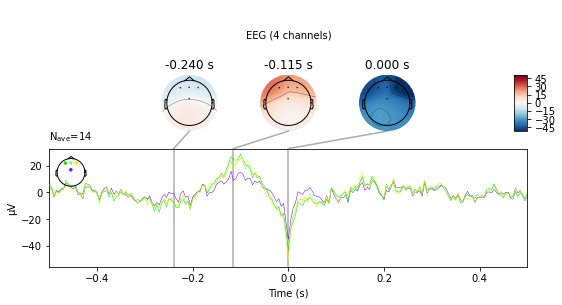

No projector specified for this dataset. Please consider the method self.add_proj.


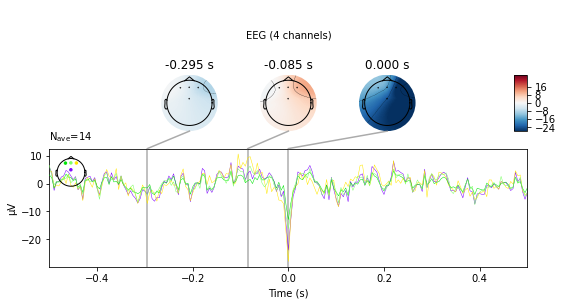

In [137]:
def plot_eog_epoch_excluded(eog_epochs, ica, exclude):
    %matplotlib inline
    ica_eog_epochs = eog_epochs.copy()
    
    ica.exclude = exclude
    ica.apply(ica_eog_epochs)
    eog_epochs.average().plot_joint();
    ica_eog_epochs.average().plot_joint();
    
plot_eog_epoch_excluded(eog_epochs, ica, eog_indices)

[1]
Applying ICA to Epochs instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


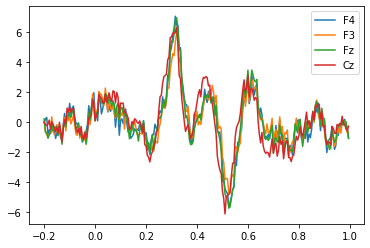

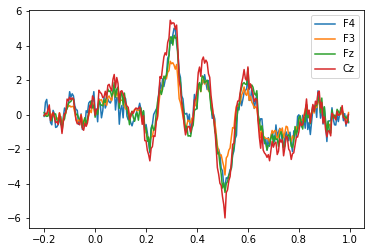

In [136]:

def plot_cleaned_averages(epochs, ica, exclude, event=1):
    %matplotlib inline
    evoked = epochs.average(by_event_type=True)
    evoked_times = evoked[event].times
    evoked_data = evoked[event].get_data(units='uV')
    
    ica_epochs = epochs.copy()
    ica.exclude = exclude
    ica.apply(ica_epochs)
    ica_evoked = ica_epochs.average(by_event_type=True)
    ica_evoked_times = ica_evoked[event].times
    ica_evoked_data = ica_evoked[event].get_data(units='uV')
    
    ch_names = [chs['ch_name']for chs in evoked[0].info['chs']]
    for ch_evo, ch_name in zip(evoked_data, ch_names):
        plt.plot(evoked_times, ch_evo, label=ch_name)
    plt.legend()
    plt.show()
    
    for ica_ch_evo, ch_name in zip(ica_evoked_data, ch_names):
        plt.plot(ica_evoked_times, ica_ch_evo, label=ch_name)
    plt.legend()
    plt.show()

print(eog_indices)
plot_cleaned_averages(epochs, ica, exclude=[1], event=1)

# Scrap Code

Compares epoch vs raw concat then epoching to make sure the same results are produced.

(975, 4, 240) (975, 4, 240)


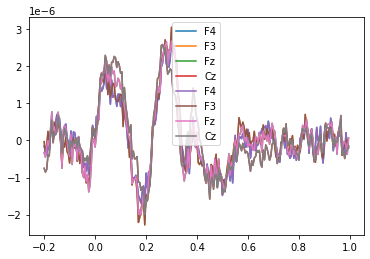

In [74]:
def plot_all_channels(x, y, ch_names, ax):
    for data, ch_name in zip(x, ch_names):
        ax.plot(y, data, label=ch_name)

c_epoch_x = epochs_autodroppped.get_data()
epoch_x = epochs.get_data()
print(c_epoch_x.shape, epoch_x.shape)

assert epochs.drop_log == epochs_autodroppped.drop_log

avg_c_epochs = epochs_autodroppped.average(by_event_type=True)[1]
avg_epochs = epochs.average(by_event_type=True)[1]

assert np.all(avg_c_epochs.get_data() == avg_epochs.get_data())
fig, ax = plt.subplots()

plot_all_channels(avg_c_epochs.get_data(), avg_c_epochs.times, avg_c_epochs.ch_names, ax=ax)
plot_all_channels(avg_epochs.get_data(), avg_epochs.times, avg_epochs.ch_names, ax=ax)
plt.legend()

Testing MNE viz compare evoked. Very limiting.

In [ ]:
%matplotlib inline
def sample(index_len, sample_size):
    idx = np.arange(index_len)
    return np.random.choice(idx, size=sample_size, replace=False)



sample_1 = sample(len(epochs_autodroppped['1']), 100)
sample_2 = sample(len(epochs_autodroppped['2']), len(epochs_autodroppped['1']))

# fig, ax = plt.subplots()
# df = epochs_autodroppped['1'][sample_1].average().to_data_frame()
# df.melt(id_vars=['time'], 
#         value_vars=epochs_autodroppped.ch_names, 
#         value_name='uV',
#         var_name='channels')
avg1 = epochs_autodroppped['1'].average()
# ax.plot(avg_1.times, avg_1.get_data())
avg2 = epochs_autodroppped['2'].average()

mne.viz.plot_compare_evokeds(
    dict(ern=avg1, crn=avg2),
    picks=['Cz', 'Fz'],
    combine='mean',
    show=True);

Attempting to find EOG events in raw data and label them in epoched data so we can see which epochs contain eye blinks or artifacts marked by autolabeling.

In [ ]:
import math
min_idx = int(abs(epochs.tmin * epochs.info['sfreq']))
max_idx = int(abs(math.ceil(epochs.tmax) * epochs.info['sfreq']))

print(min_idx, max_idx)

def get_epochs_with_eog_events(epochs, filt_raw, eog_events):
    min_idx = int(abs(epochs.tmin * epochs.info['sfreq']))
    max_idx = int(abs(math.ceil(epochs.tmax) * epochs.info['sfreq']))
    eog_event_idxs = eog_epochs.events[:, 0]
    for event in epochs.events():
        filt_raw_idx = event[0] 
        epoch_start = epochs.events[0, 0] - min_idx
        epoch_end = epochs.events[0, 0]  + max_idx

epoch_start = epochs.events[0, 0] - min_idx
epoch_end = epochs.events[0, 0]  + max_idx
filt_raw_arr = filt_raw.get_data()

np.all(filt_raw_arr[0, epoch_start:epoch_end] ==  epochs.get_data()[0, 0])
eog_event_idxs = eog_epochs.events[:, 0]
bools = np.where(np.logical_and(
    epoch_start <= eog_event_idxs,  eog_event_idxs < epoch_end))[0]
bools

Confirming the 'id' column captures each unique epoch for every subject and event combo.

In [ ]:
tdf = subject_df.loc['dbci', 'BGSInt', ['1', '2']]
tdf[tdf['event'] == '1']['epoch'].unique().shape

print(tdf.index.names)
rtdf = tdf.reset_index()
samples = rtdf['id'].sample(n=100)
rtdf = rtdf.set_index(['id'])
print(len(rtdf.loc[samples.values]) / 240 / 4)
rtdf.loc[samples.values].reset_index().set_index(tdf.index.names)